In [1]:
import numpy as np
import scipy as sp
from scipy.spatial import distance
class kEDMD:
    def __init__(self, X, Y, kernel="gaussian", **kwargs):
        """
        X: N_dim * M_data
        Y: N_dim * M_data
        """
        self.X = X
        self.Y = Y
        self.kernel = kernel
        
        if self.kernel == "gaussian":
            assert "eps" in kwargs, "gaussian kernel needs eps param"
            self.eps = kwargs["eps"]
            self.f = self.gramian
        elif self.kernel == "polynomial":
            assert ("p" in kwargs) and ("c" in kwargs), "polynomial kernel needs c and p param"
            self.p = kwargs["p"]
            self.c = kwargs["c"]
            if "gamma" in kwargs:
                self.gamma = kwargs["gamma"]
            else:
                self.gamma = 1.0
            self.f = self.polynomial
        
    def fit(self, truncation=1e-3):
        
        self.G = self.f(self.X, self.X)
        self.A = self.f(self.X, self.Y)
        
        # 低ランク近似
        U, s, V = sp.linalg.svd(self.G)
        mask = s > truncation
        U = U[:, mask]
        V = V[mask, :]
        S_inv = np.diag(1/s[mask])
        # カーネルクープマン行列を求める
        self.K = V.T @ S_inv @ U.T @ self.A
        self.calc_modes(truncation=truncation)
        return None
        
    def calc_modes(self, truncation=1e-3):
        # 固有値,固有ベクトルを求める
        self.eigenvalues, self.eigenvectors = sp.linalg.eig(self.K)

        # Kを求めるときに使った各データ点x1, x2, ..., xMを用いて，固有関数の値を求める
        # Gは対称行列なので下のコードのように転置を取らなくても良い
        # 低ランク近似（必要に応じて、必要なければtruncation=0にすれば良い）
        self.modes = sp.linalg.pinv(self.G.T @ self.eigenvectors, rtol=truncation) @ self.X.T
        return None

    def calc_eigenfunction(self, x):
        M = self.X.shape[1] # num_data
        self.eigenfuncion = np.zeros([M])
        
        #次の座標を予測したいデータ点を入力とする固有関数の値を求める
        if self.kernel == "gaussian":
            phi_Xx = np.exp(-np.linalg.norm(self.X - x.reshape(-1,1), axis=0)**2/(2*(self.eps**2))) @ self.eigenvectors
        elif self.kernel == "polynomial":
            phi_Xx = (self.c + x.T @ self.X)**self.p @ self.eigenvectors
        return phi_Xx
        
    def predict(self, x):
        """
        x: 1 * N_dim
        return: 1 * N_dim
        """
        phi_Xx = self.calc_eigenfunction(x)
        return np.real((self.eigenvalues * phi_Xx.flatten()) @ self.modes).T

    def gramian(self, X, Y):
        return np.exp(-distance.cdist(X.T, Y.T, 'sqeuclidean')/(2*(self.eps**2)))
         
    def polynomial(self, X, Y):
        """
        c: param
        d: order
        X: D * M次元
        Y: D * M次元
        return Gram matrix, each element = k(x_i, y_i)
        """
        M = X.shape[1]
        G = np.zeros([M, M])
        for i in range(M):
            for j in range(M):
                G[i, j] += (self.gamma*(Y[:, i].T @X[:, j]) + self.c)**self.p
        return G

def svd_update(U, s, V, a, b):
    m = U.T @ a
    n = V @ b
    p = a - U @ m
    q = b - V.T @ n
    Ra = np.linalg.norm(p)
    Rb = np.linalg.norm(q)
    P = p/Ra
    Q = q/Rb
    
    K = np.append(m, Ra).reshape(-1,1) @ np.append(n, Rb).reshape(-1,1).T
    K[:-1, :-1] += np.diag(s)
    U_prime, s_prime, V_prime = np.linalg.svd(K)
    UpdatedU = np.hstack([U, P]) @ U_prime
    UpdatedV = np.hstack([V.T, Q]) @ V_prime.T
    
    return UpdatedU, s_prime, UpdatedV.T

def polynomial_kernel(X, Y, gamma=1, d=5, c=1):
    """
    X: D * M次元
    Y: D * M次元
    return Gram matrix, each element = k(x_i, y_i)
    """
    M = X.shape[1]
    G = np.zeros([M, M])
    for i in range(M):
        for j in range(M):
            G[i, j] += (gamma*(Y[:, i].T @X[:, j]) + c)**d
    return G

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp


def lorentz(t, x, sigma, rho, beta):
    dx0dt = sigma * (x[1] - x[0])
    dx1dt = rho * x[0] - x[1] - x[0]*x[2]
    dx2dt = x[0] * x[1] - beta * x[2]
    return [dx0dt, dx1dt, dx2dt]

time_step = [0, 5]
sigma = 10
rho = 28
beta = 8
np.random.seed(100)
initial_value = np.random.uniform(low=-15, high=15, size=3)
print(initial_value)
sol_lorentz = solve_ivp(lorentz, t_span=time_step, y0=initial_value, args=[sigma, rho, beta], rtol=1e-8, t_eval=np.arange(0, 5, 0.01))
solution_lorentz = (sol_lorentz.y - np.min(sol_lorentz.y, axis=1).reshape(-1, 1)) / (np.max(sol_lorentz.y, axis=1) - np.min(sol_lorentz.y, axis=1)).reshape(-1,1)
initial_value = (initial_value.reshape(-1,1) - np.min(sol_lorentz.y, axis=1).reshape(-1, 1)) / (np.max(sol_lorentz.y, axis=1) - np.min(sol_lorentz.y, axis=1)).reshape(-1,1)

x = solution_lorentz[0]
y = solution_lorentz[1]
z = solution_lorentz[2]
X_lorentz = solution_lorentz[:, :-1]
Y_lorentz = solution_lorentz[:, 1:]
print("done")

[ 1.30214825 -6.64891845 -2.26447228]
done


In [3]:
# kernel EDMD
# 閾値

# カーネルKoopman行列を求める
#K_kernel = sp.linalg.inv((G_hat + c*np.eye(M,M))) @ A_hat
kedmd = kEDMD(X_lorentz, Y_lorentz, kernel="polynomial", p=10, c=1)
kedmd.fit(truncation=1e-5)

# 予測値を求める
pred = []
print(X_lorentz.shape)
for x in X_lorentz.T:
    pred.append(kedmd.predict(x))
print("done")

(3, 499)
done


In [4]:
G_hat = polynomial_kernel(X_lorentz, X_lorentz, gamma=1.0, d=10, c=1)
A_hat = polynomial_kernel(X_lorentz, Y_lorentz, gamma=1.0, d=10, c=1)

# G_hatの低ランク近似
threshold = 1e-5
U, S, V = sp.linalg.svd(G_hat)
mask = S > threshold
U = U[:, mask]
V = V[mask, :]
S_inv = np.diag(1 / S[mask])
K_kernel = V.T @ S_inv @ U.T @ A_hat

# Koopman eigenvalue, vector
d_kernel, V_kernel = sp.linalg.eig(K_kernel)
eigf_x = G_hat.T @ V_kernel
# モードを求める
modes_data = sp.linalg.pinv(eigf_x, rtol=1e-5) @ X_lorentz.T
y_kedmd =  np.real((d_kernel * eigf_x) @ modes_data).T
error_kedmd = np.linalg.norm(y_kedmd - Y_lorentz, axis=0).mean()

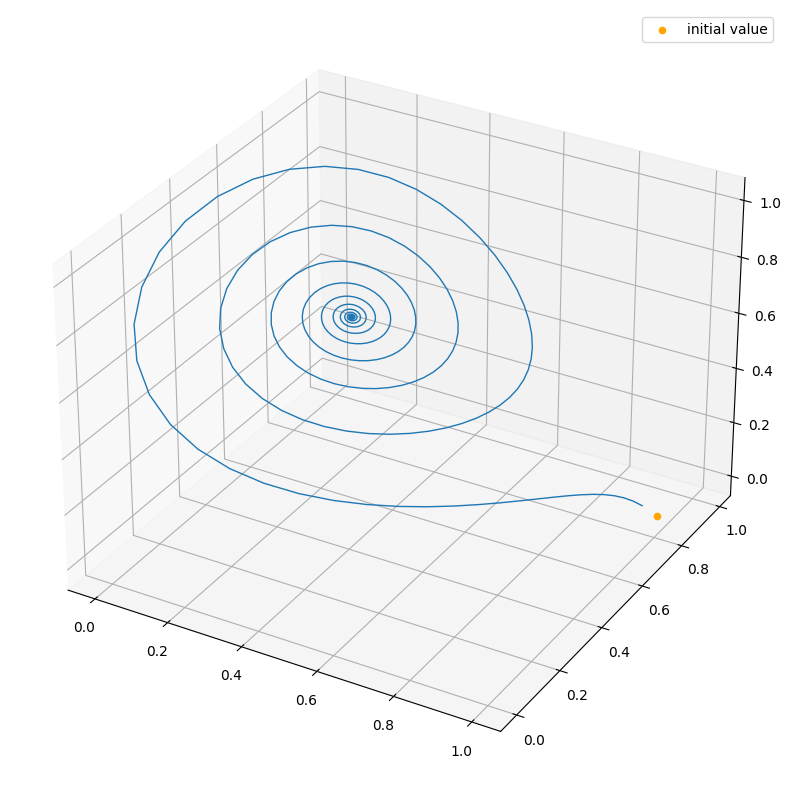

In [5]:
#y_kedmd = np.real((kedmd.eigenvalues * kedmd.eigenfunction) @ kedmd.modes).T
y_kedmd = np.array(pred).T
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(initial_value[0], initial_value[1],initial_value[2], color="orange", label="initial value")
# ax.set_xlabel("x", fontsize=10)
# ax.set_ylabel("y", fontsize=10)
# ax.set_zlabel("z", fontsize=10)
#ax.set_title("kEDMD prediction, n_data={}".format(G_hat.shape[0]), fontsize=10)
ax.plot(y_kedmd[0], y_kedmd[1], y_kedmd[2], linewidth=1)
plt.legend(loc="upper right", fontsize=10)
plt.show()

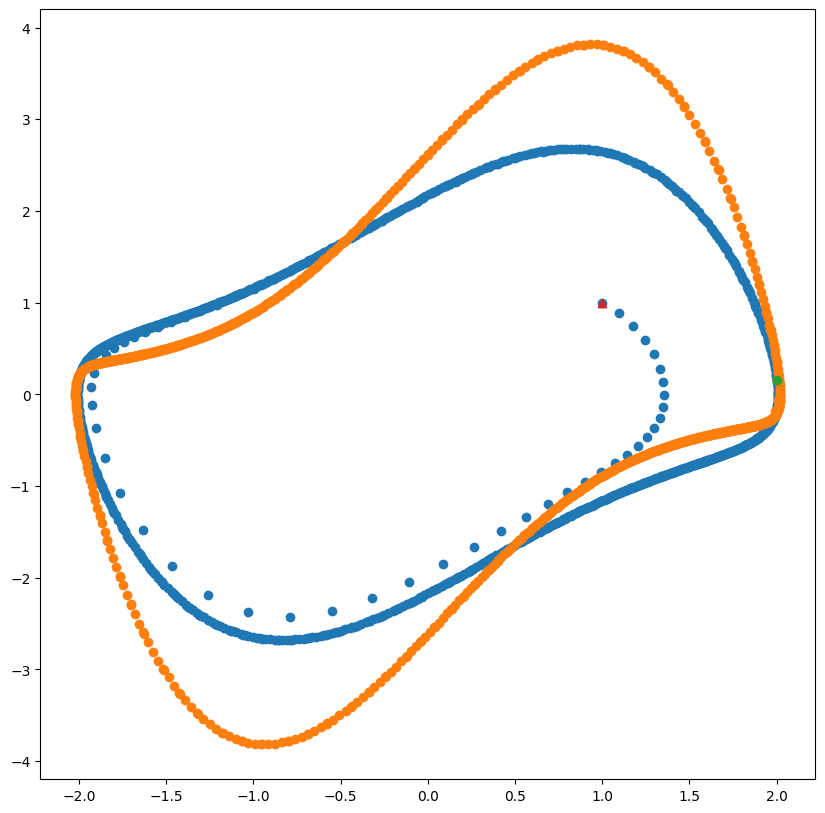

In [6]:
def van_der_pol(t, x, mu):
    dx0dt = x[1]
    dx1dt = mu*(1 - x[0]**2)*x[1] - x[0]
    return [dx0dt, dx1dt]
initial_value = [1., 1.]
time_step1 = (0, 100)
time_step2 = (100, 200)
mu_0 = 1
mu_1 = 2
T = 100
X_t = []
Y_t = []
solution1 = solve_ivp(van_der_pol, t_span=time_step1, y0=initial_value, args=[mu_0],rtol=1e-8, t_eval=np.arange(0,100,0.1))
medium_value = solution1.y[:, -1]

solution2 = solve_ivp(van_der_pol, t_span=time_step2, y0=medium_value, args=[mu_1],rtol=1e-8, t_eval=np.arange(100,200,0.1))
plt.figure(figsize=(10, 10))
plt.scatter(solution1.y[0], solution1.y[1])
plt.scatter(solution2.y[0], solution2.y[1])
plt.scatter(medium_value[0], medium_value[1])
plt.scatter(initial_value[0], initial_value[1], marker="^")
plt.show()

In [7]:
X_vdp = solution1.y[:, :-1] 
Y_vdp = solution1.y[:, 1:] 

In [81]:
# kernel EDMD
# 閾値
error = []
for i in range(10, 100):
    num_data = i
    # カーネルKoopman行列を求める
    #K_kernel = sp.linalg.inv((G_hat + c*np.eye(M,M))) @ A_hat
    kedmd_poly = kEDMD(X_vdp[:, :num_data], Y_vdp[:, :num_data], kernel="polynomial", p=3, c=1)
    kedmd_gauss = kEDMD(X_vdp[:, :num_data], Y_vdp[:, :num_data], kernel="gaussian", eps=np.sqrt(5))
    
    # K_dmd = Y_vdp[:, :30].T @ np.linalg.pinv(X_vdp[:, :30].T)
    # evals, evec = np.linalg.eig(K_dmd)
    # modes = sp.linalg.pinv(X_vdp[:, :30] @ evec, rtol=1e-3) @ X_vdp
    # efunc = X_vdp[:, :30] @ evec
    # y_dmd = np.real((evals * efunc) @ modes)
    
    
    kedmd_gauss.fit(truncation=1e-5)
    kedmd_poly.fit(truncation=1e-5)
    
    # 予測値を求める
    pred_gauss = [X_vdp[:, num_data]]
    pred_poly = [X_vdp[:, num_data]]
    for x in X_vdp[:, num_data:-1].T:
        pred_gauss.append(kedmd_gauss.predict(x))
        pred_poly.append(kedmd_poly.predict(x))
    y_kedmd_poly = np.array(pred_poly).T
    error.append(np.linalg.norm(Y_vdp[:, num_data:]-y_kedmd_poly, axis=0).mean())
print("done")

10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
done


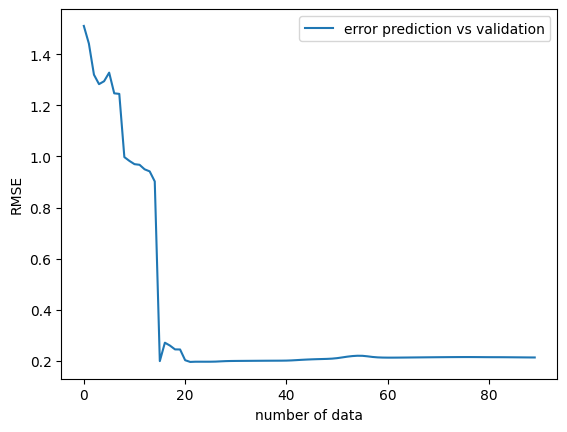

In [83]:
plt.plot(np.arange(0, len(error)), np.array(error), label="error prediction vs validation")
plt.xlabel("number of data")
plt.ylabel("RMSE")
plt.legend()
plt.show()

30
[0.202859480699264]


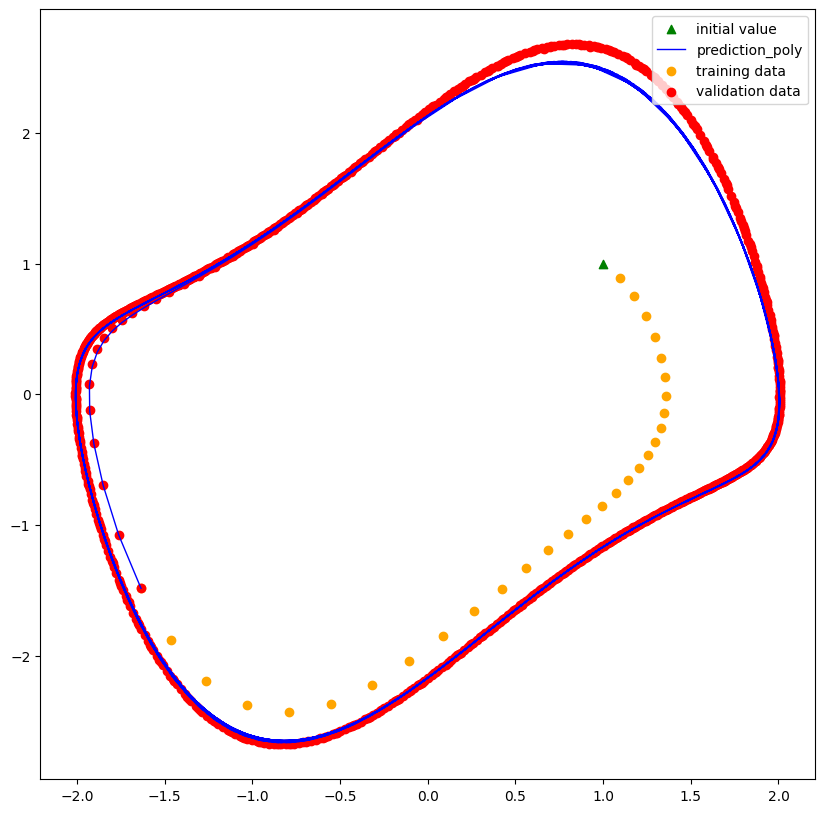

In [99]:
#y_kedmd = np.real((kedmd.eigenvalues * kedmd.eigenfunction) @ kedmd.modes).T
error=[]
num_data = 30
for i in range(num_data, num_data+1):
    num_data = i
    # カーネルKoopman行列を求める
    #K_kernel = sp.linalg.inv((G_hat + c*np.eye(M,M))) @ A_hat
    kedmd_poly = kEDMD(X_vdp[:, :num_data], Y_vdp[:, :num_data], kernel="polynomial", p=3, c=1)
    kedmd_gauss = kEDMD(X_vdp[:, :num_data], Y_vdp[:, :num_data], kernel="gaussian", eps=np.sqrt(5))
    
    # K_dmd = Y_vdp[:, :30].T @ np.linalg.pinv(X_vdp[:, :30].T)
    # evals, evec = np.linalg.eig(K_dmd)
    # modes = sp.linalg.pinv(X_vdp[:, :30] @ evec, rtol=1e-3) @ X_vdp
    # efunc = X_vdp[:, :30] @ evec
    # y_dmd = np.real((evals * efunc) @ modes)
    
    
    kedmd_gauss.fit(truncation=1e-5)
    kedmd_poly.fit(truncation=1e-5)
    
    # 予測値を求める
    pred_gauss = [X_vdp[:, num_data]]
    pred_poly = [X_vdp[:, num_data]]
    for x in X_vdp[:, num_data:-1].T:
        pred_gauss.append(kedmd_gauss.predict(x))
        pred_poly.append(kedmd_poly.predict(x))
    y_kedmd_poly = np.array(pred_poly).T
    error.append(np.linalg.norm(Y_vdp[:, num_data:]-y_kedmd_poly, axis=0).mean())
    print(i)

y_kedmd_gauss = np.array(pred_gauss).T
y_kedmd_poly = np.array(pred_poly).T
print(error)
fig = plt.figure(figsize=(10, 10))
plt.scatter(initial_value[0], initial_value[1], marker="^", color="green", label="initial value")
#plt.plot(y_kedmd_gauss[0], y_kedmd_gauss[1], linewidth=1, label="prediction_gauss", color="red", linestyle="dashdot")
plt.plot(y_kedmd_poly[0], y_kedmd_poly[1], linewidth=1, label="prediction_poly", color="blue", linestyle="solid")
#plt.scatter(y_dmd[0], y_dmd[1], linewidth=1, label="prediction_dmd", color="green")
plt.scatter(Y_vdp[0, :num_data], Y_vdp[1, :num_data], label="training data", color="orange")
plt.scatter(X_vdp[0, num_data:], X_vdp[1, num_data:], label="validation data", color="red")
plt.legend(loc="upper right", fontsize=10)
plt.show()

In [174]:
from scipy.sparse import csr_matrix as sparse_matrix

# scipy.sparse.csr_matrix
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html


def make_differential_ops(nx, dx):

    # operators (matrix) that shift vector components (periodic boundary condition)
    f0 = np.identity(nx, dtype=int)  # f_{i}
    f1 = np.roll(f0, 1, axis=1)  # f_{i+1}
    f2 = np.roll(f0, 2, axis=1)  # f_{i+2}
    f_1 = f1.transpose()  # f_{i-1}
    f_2 = f2.transpose()  # f_{i-2}

    # (f_{i+1} - f_{i-1}) / (2 dx)
    deriv1 = sparse_matrix(f1 - f_1) / (2.0 * dx)

    # (f_{i+1} - 2f_{i} + f_{i-1}) / (dx^2)
    deriv2 = sparse_matrix(f1 - 2.0 * f0 + f_1) / dx**2

    # (f_{i+2} - 2f_{i+1} + 2f_{i-1} - f_{i-2}) / (2 dx^3)
    deriv3 = sparse_matrix(f2 - 2.0 * f1 + 2.0 * f_1 - f_2) / (2.0 * dx**3)

    return deriv1, deriv2, deriv3
coeff_nlin = 6.0
coeff_dis = 1.0
alpha = coeff_nlin/(6.0 * coeff_dis)

[e_1, e_2,e_3]= [-4.0,0.0,2.0]
elliptic_k = (e_3-e_2)/(e_3-e_1)
from scipy.special import ellipj, ellipk


def f_kdv(t, u, df1, df3):
    u_x = df1.dot(u)
    u_xxx = df3.dot(u)
    return coeff_nlin * u * u_x + coeff_dis* u_xxx

def main():
    # x mesh
    sys_length = (2*ellipk(elliptic_k))/np.sqrt(2*(e_3-e_1))
    nx = 50
    x_max = sys_length #100.0　# 本家から変えたところ
    x = np.linspace(-x_max, x_max, nx, endpoint=False)
    dx = x[1] - x[0]
    print("dx =", dx)

    # initial condition
    # 本家から変えた。
    # u0 = np.sin(x * (2.0 * np.pi / x_max))
    [_,cn,_,_] = ellipj(np.sqrt(alpha * (e_3-e_1)/2)*x, elliptic_k)
    u0 = e_2 + (e_3-e_2)* cn **2

    

    # differential operators
    op_df1, _, op_df3 = make_differential_ops(nx, dx)

    print("Solving equation...")
    t_max = 0.5
    sol = solve_ivp(f_kdv, (0, t_max), u0, dense_output=True, args=(op_df1, op_df3), rtol=1e-8)
    print(sol.message)
    print(" Number of time steps :", sol.t.size)
    print(" Minimam time step    :", min(np.diff(sol.t)))
    print(" Maximum time step    :", max(np.diff(sol.t)))

    # t mesh
    nt = 101
    t = np.linspace(0, t_max, nt)
    dt = t[1] - t[0]
    print("dt =", dt)

    # get u(t, x)
    u_xt = sol.sol(t)  # u(x, t)
    u_tx = u_xt.T  # u(t, x)
    print("shape of u(t, x) :", u_tx.shape)

    # Save results
    np.savez("kdv_solve_ivp", x=x, t=t, u_tx=u_tx)
    return (x, t, u_tx)

x, t, u_tx = main()

dx = 0.04004309521824423
Solving equation...
The solver successfully reached the end of the integration interval.
 Number of time steps : 18523
 Minimam time step    : 2.0676951011600053e-05
 Maximum time step    : 0.0013038190442814213
dt = 0.005
shape of u(t, x) : (101, 50)


npz.files = ['x', 't', 'u_tx']
x.shape = (50,)
t.shape = (101,)
u_tx.shape = (101, 50)
Making animation...
saved as 'kdv_solve_ivp.gif'


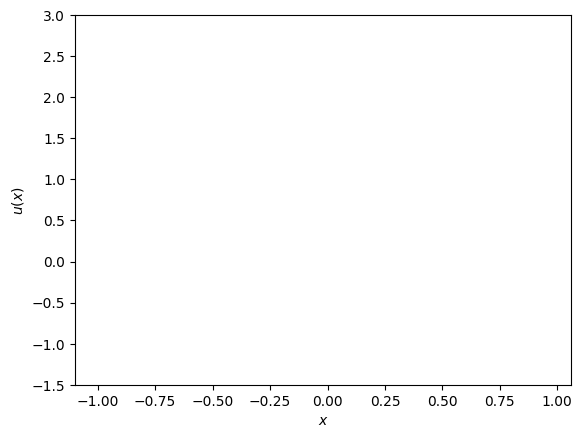

In [162]:
import matplotlib.animation as animation

def save_animation(x, t, u_tx, ymin, ymax, filename):
    fig, ax = plt.subplots()

    # common setting for plot
    ax.set_xlabel("$x$")
    ax.set_ylabel("$u(x)$")
    ax.set_ylim((ymin, ymax))

    artists = []  # list of plot
    for i in range(t.size):
        # Make i-th plot
        # ax.set_title("t = %f" % t[i])
        artist = ax.plot(x, u_tx[i, :], '-b')
        artist += [ax.text(0.05, 1.05, "t = %.2f" % t[i], transform=ax.transAxes)]
        artists.append(artist)

    # Make animation
    anim = animation.ArtistAnimation(fig, artists, interval=100, repeat=False)
    # plt.show()

    # Save animation
    anim.save(filename, writer="pillow")  # writer="pillow" or "imagemagick" for GIF
    print("saved as '{}'".format(filename))
def load_and_make_anime():
    # Load results
    npz = np.load("kdv_solve_ivp.npz")
    print("npz.files =", npz.files)

    x = npz['x']
    t = npz['t']
    u_tx = npz['u_tx']
    print("x.shape =", x.shape)
    print("t.shape =", t.shape)
    print("u_tx.shape =", u_tx.shape)

    # make an animation
    print("Making animation...")
    save_animation(x, t, u_tx, ymin=-1.5, ymax=3.0, filename="kdv_solve_ivp.gif")
load_and_make_anime()

In [269]:
# dim * data
num_data = 25
X_kdv = u_tx[:, :-1]
Y_kdv = u_tx[:, 1:]
print(Y_kdv.shape)
# kedmd
kedmd_kdv = kEDMD(X_kdv[:, :num_data], Y_kdv[:, :num_data], kernel="polynomial", p=3, c=1)
kedmd_kdv.fit()

(101, 49)


In [270]:
preds = []
for _ in X_kdv[:, num_data:].T:
    _ = _.reshape(-1, 1)
    preds.append(kedmd_kdv.predict(_))
preds = np.array(preds)
print(preds.shape)

(24, 101)


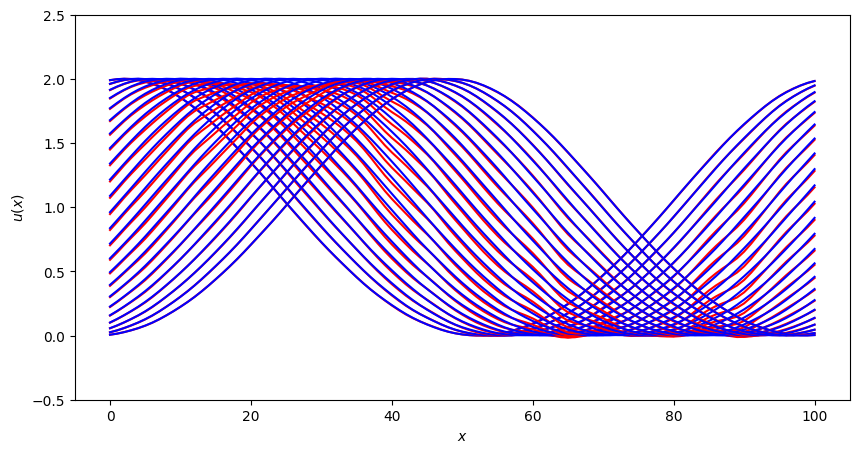

In [271]:
fig, ax = plt.subplots(figsize=(10,5))
ax1 = ax
ax1.set_xlabel("$x$")
ax1.set_ylabel("$u(x)$")
ax1.set_ylim((-0.5, 2.5))
artists = []  # list of plot
for i in range(preds.shape[0]):
    artist1 = ax1.plot(preds[i, :], '-r')
    artist2 = ax1.plot(Y_kdv[:, num_data+i], '-b')
    artists.append(artist1+artist2)

# Make animation
anim = animation.ArtistAnimation(fig, artists, interval=100, repeat=False)
plt.show()
# Save animation
anim.save("kedmd_prediction.gif", writer="pillow")  # writer="pillow" or "imagemagick" for GIF

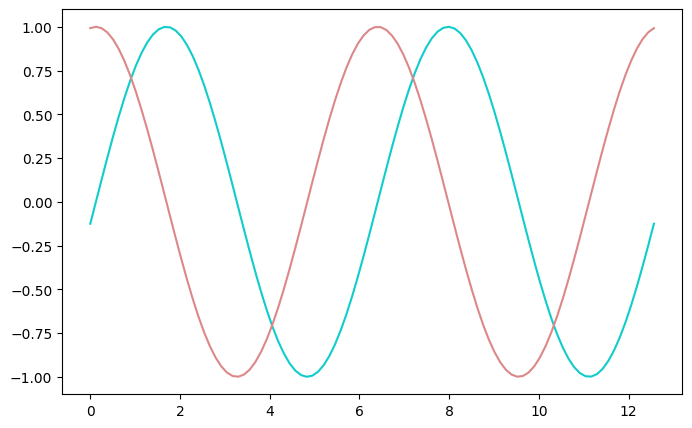

In [234]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)

lim = 50
xs = np.linspace(0, 4*np.pi, 100)
images = []

for i in range(lim):
    theta = i*2*np.pi/lim
    ys1 = np.sin(xs+theta)
    ys2 = np.cos(xs+theta)
    image1 = ax.plot(xs, ys1, c="#11cccc")
    image2 = ax.plot(xs, ys2, c="#dd8888")

    images.append(image1 + image2)

anime = animation.ArtistAnimation(fig, images, interval=40, blit=True, repeat_delay=0)
anime.save("sin_cos.gif", writer="pillow")
plt.show()